In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
import pandas as pd
import scipy
import xarray as xr

In [3]:
# If Surface fluxes are available
SF = True

In [4]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

## ERA5 begins in 1979 so we have to change our "early" and "late" periods
dyrs = 9
init_early = 1979
init_late = 2006
Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
range_yrs = init_late-init_early+1

In [5]:
%%time
ERA5_BSP_data = xr.open_mfdataset('BSP_processed/BSP_ERA5_TS_*.nc')

## Early Period
Part_early = ERA5_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ERA5_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ERA5_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
V_early = ERA5_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ERA5_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
Asection_early = ERA5_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ERA5_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ERA5_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ERA5_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
V_late = ERA5_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ERA5_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
Asection_late = ERA5_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ERA5_BSP_data.Basin.values
Sections = ERA5_BSP_data.Section.values


CPU times: user 475 ms, sys: 65.9 ms, total: 541 ms
Wall time: 993 ms


In [6]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()
AS_1 = Asection_early.values.flatten()
AS_2 = Asection_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [7]:
## LOAD T and S data from a gridded observations (e.g., we use EN4 here)
## For the purposes of the tutorial we only select the first 3 months of the data
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_*')

lats = data.lat.values
lons = data.lon.values

SST = data.Cons_Temp.isel(time=slice(Early_period[0],Early_period[1])).mean('time', keepdims=True).isel(depth=0)
land_mask = (SST/SST).load()
V = data.dVol.isel(time=slice(Early_period[0],Early_period[1])).mean('time').load()
darea = (data.dArea.isel(time=slice(Early_period[0],Early_period[1])).mean('time')*land_mask).load()

In [8]:
## Load ERA5 data here, if provided
if SF:
    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum = ERA5_BSP_data.hfds_sum.cumsum('Time').isel(Time=-1)*(1/(24*3600))*(yr2sec/12) # units: J
    WFO_cumsum = ERA5_BSP_data.wfo_sum.cumsum('Time').isel(Time=-1)*(yr2sec/12) # units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs)) # units: J
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs)) # units: kg

    ## Get it in W/m2 and mm/day
    dhfds_flux = dhfds/(range_yrs*yr2sec*A_early)
    dwfo_flux = dwfo/(range_yrs*yr2sec*A_early*rho)*1000*24*3600

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # units: C
    dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg

    time = ERA5_BSP_data.Time.values
    
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0

In [9]:
if SF:
    data_ERA5 = xr.open_mfdataset('~/UNSW_Work/ERA5/*') ## hfds: J; wfo: kgs^-1

    ## Calculate the cumulative time integrated surface fluxes 
    HFDS_cumsum_ERA5 = data_ERA5.hfds.cumsum('time').isel(time=-1)*(1/(24*3600))*(yr2sec/12) # units: J
    WFO_cumsum_ERA5 = data_ERA5.wfo.cumsum('time').isel(time=-1)*yr2sec/12 # units: kg

    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds_ERA5 = HFDS_cumsum_ERA5*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs)) # units: J
    dwfo_ERA5 = WFO_cumsum_ERA5*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-dyrs)) # units: kg

    ## Convert to units of interest
    dhfds_ERA5_Wm2 = dhfds_ERA5/(range_yrs*yr2sec*darea) # units: W/m2
    dwfo_ERA5_mm_day = dwfo_ERA5/(range_yrs*yr2sec*darea*rho)*1000*24*3600 # units: mm/day

In [10]:
if SF:
    Opt_result = xr.open_mfdataset('Optimisation_results/Optimal_result_EN4_SF_79_06.nc')
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
else:
    Opt_result = xr.open_mfdataset('Optimisation_results/Optimal_result_EN4.nc')
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')

mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

In [11]:
EN4_mapped_masks = xr.open_mfdataset('Masks_processed/Masks_EN4_108*.nc')
fuzz_combined = EN4_mapped_masks.fuzz.isel(depth=0).values

mask_EN4_xr = xr.open_mfdataset('Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)
dhfds_flux_vals = dhfds_flux.values
dwfo_flux_vals = dwfo_flux.values


In [12]:
dS_adj = Opt_result.dS_adjustment.values.reshape(Basins.size,SA_early.shape[-1])
dT_adj = Opt_result.dT_adjustment.values.reshape(Basins.size,SA_early.shape[-1])

dwfo_adj = -dS_adj*(rho*V_early.values)/S0 # units: kg
dhfds_adj = dT_adj*(Cp*rho*V_early.values) # units: J

## Get it in W/m2 and mm/day
dhfds_flux_adj = dhfds_adj/(range_yrs*yr2sec*A_early.values)
dwfo_flux_adj = dwfo_adj/(range_yrs*yr2sec*A_early.values*rho)*1000*24*3600

In [13]:
if SF:
        hfds_tot = 0
        wfo_tot = 0
        for i in (range(SA_early.shape[-1])):
                tmp_dhfds = 0
                tmp_dwfo = 0
                for j in range(Basins.size):
                        tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_vals[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dhfds = tmp+tmp_dhfds
                        tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_vals[j,i]
                        tmp[np.isnan(tmp)] = 0
                        tmp_dwfo = tmp+tmp_dwfo
                hfds_tot = tmp_dhfds+hfds_tot
                wfo_tot = tmp_dwfo+wfo_tot

dS_adj_tot = 0
dT_adj_tot = 0
for i in (range(SA_early.shape[-1])):
    tmp_dS_adj = 0
    tmp_dT_adj = 0
    for j in range(Basins.size):
            tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dwfo_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dS_adj = tmp+tmp_dS_adj
            tmp = mask_EN4[j,:,:]*fuzz_combined[i,:,:]*dhfds_flux_adj[j,i]
            tmp[np.isnan(tmp)] = 0
            tmp_dT_adj = tmp+tmp_dT_adj
    dS_adj_tot = tmp_dS_adj+dS_adj_tot
    dT_adj_tot = tmp_dT_adj+dT_adj_tot

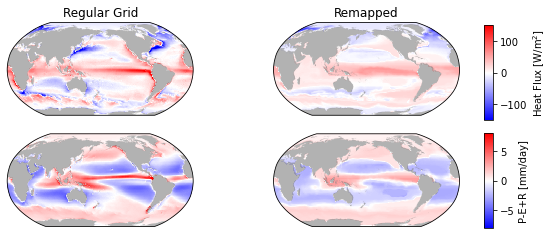

In [14]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -150,150

    dhfds_ERA5_Wm2.plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)


    ax2.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -8,8
    dwfo_ERA5_mm_day.plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)


    ax4.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax1.set_title('Regular Grid')
    ax2.set_title('Remapped')
    ax3.set_title('')
    # ax4.set_title('Accumulated P-E+R (Remapped)')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('Figures/net_hfds_wfo_ERA5.png', bbox_inches='tight', dpi=300)

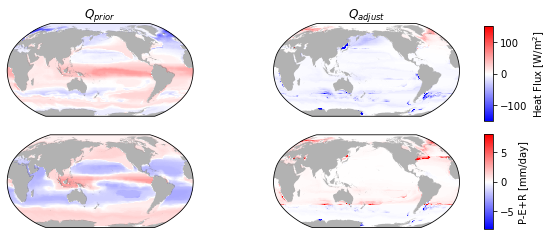

In [15]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.2, hspace=0.2)

    ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)),\
            plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -150,150

    ax1.pcolormesh(lons, lats,  hfds_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())


    ax2.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    cax = fig.add_axes([0.91, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Heat Flux [W/m$^2$]')

    minv, maxv = -8,8

    ax3.pcolormesh(lons, lats, wfo_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax4.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

    ax1.set_title('$Q_{prior}$')
    ax2.set_title('$Q_{adjust}$')
    ax3.set_title('')
    # ax4.set_title('Accumulated P-E+R (Remapped)')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('P-E+R [mm/day]')
    plt.savefig('Figures/hfds_wfo_adj_vs_actual.png', bbox_inches='tight', dpi=300)

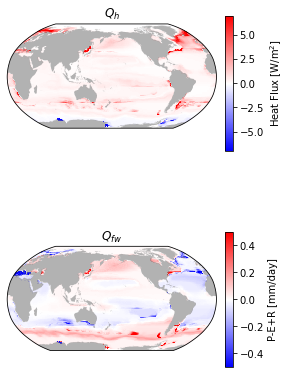

In [90]:
fig  = plt.figure(1, figsize = (7.5*0.5, 7.5))
gs = gridspec.GridSpec(2,1)
gs.update(wspace = 0.1, hspace=0.2)

ax1, ax2 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180))
minv, maxv = -7,7

ax1.pcolormesh(lons, lats,  dT_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

cax = fig.add_axes([0.93,0.57, 0.03, 0.25])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Heat Flux [W/m$^2$]')

minv, maxv = -.5,.5

ax2.pcolormesh(lons, lats, dS_adj_tot, vmin=minv,vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree())

ax1.set_title('$Q_{h}$')
ax2.set_title('$Q_{fw}$')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

cax = fig.add_axes([0.93, 0.17, 0.03, 0.25])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('P-E+R [mm/day]')
plt.savefig('Figures/hfds_wfo_adj_freerun.png', bbox_inches='tight', dpi=300)

In [33]:
## Run below code when MTM is modified, otherwise comment it
## Takes approx 8 mins to run

In [34]:
# run MTM_remapping_EN4.ipynb

  0%|          | 0/128 [00:00<?, ?it/s]

In [39]:
if SF:
    dT_mix = xr.open_mfdataset('Remapped_props/dT_mix_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    dS_mix = xr.open_mfdataset('Remapped_props/dS_mix_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    dT_adj = xr.open_mfdataset('Remapped_props/dT_adj_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    dS_adj = xr.open_mfdataset('Remapped_props/dS_adj_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    g_ij_3D = xr.open_mfdataset('Remapped_props/g_ij_Eulerian_SF.nc').__xarray_dataarray_variable__.values

    ## Convert dflux to equivalent T or S change
    hfds_mix = dT_mix*(Cp*rho*V) # units: W
    wfo_mix = -dS_mix/S0*(rho*V) # units: kg/s
    hfds_adj = dT_adj*(Cp*rho*V) # units: W
    wfo_adj = -dS_adj/S0*(rho*V) # units: kg/s

else:
    dT_mix = xr.open_mfdataset('Remapped_props/dT_mix_Eulerian.nc').__xarray_dataarray_variable__.values
    dS_mix = xr.open_mfdataset('Remapped_props/dS_mix_Eulerian.nc').__xarray_dataarray_variable__.values
    dT_adj = xr.open_mfdataset('Remapped_props/dT_adj_Eulerian.nc').__xarray_dataarray_variable__.values
    dS_adj = xr.open_mfdataset('Remapped_props/dS_adj_Eulerian.nc').__xarray_dataarray_variable__.values
    g_ij_3D = xr.open_mfdataset('Remapped_props/g_ij_Eulerian.nc').__xarray_dataarray_variable__.values


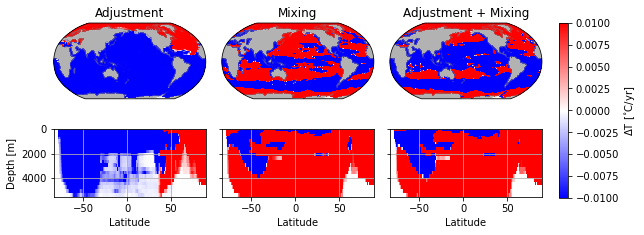

In [40]:

fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,9, height_ratios = [2,1])
gs.update(wspace = 0.4, hspace=0)


ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

ax4, ax5, ax6 = plt.subplot(gs[1,:3]), \
           plt.subplot(gs[1,3:6]), \
           plt.subplot(gs[1,6:]) 
if SF:
    minv, maxv = -0.01,0.01
    ((dT_mix*V).sum('depth')/V.sum('depth')*SST/SST).plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax2.set_title('Mixing')
    ((dT_adj*V).sum('depth')/V.sum('depth')*SST/SST).plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Adjustment')
    (((dT_adj+dT_mix)*V).sum('depth')/V.sum('depth')*SST/SST).plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('Adjustment + Mixing')

    ((dT_mix*V).sum('lon')/V.sum('lon')).plot(ax = ax5, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    ((dT_adj*V).sum('lon')/V.sum('lon')).plot(ax = ax4, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    (((dT_adj+dT_mix)*V).sum('lon')/V.sum('lon')).plot(ax = ax6, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)

else:
    minv, maxv = -0.01,0.01

    ((dT_mix*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax2.set_title('Mixing')
    ((dT_adj*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Adjustment')
    (((dT_adj+dT_mix)*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('Adjustment + Mixing')

    ((dT_mix*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax5, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    ((dT_adj*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax4, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    (((dT_adj+dT_mix)*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax6, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

ax4.invert_yaxis()
ax5.invert_yaxis()
ax6.invert_yaxis()

ax4.set_ylabel('Depth [m]')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax5.set_yticklabels([])
ax6.set_yticklabels([])

ax4.set_xlabel('Latitude')
ax5.set_xlabel('Latitude')
ax6.set_xlabel('Latitude')

ax4.grid()
ax5.grid()
ax6.grid()

cax = fig.add_axes([0.927, 0.12, 0.015, 0.65])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$\Delta$T [$^{\circ}$C/yr]')
if SF:
    plt.savefig('Figures/latlon_remapping_knownSF_dT_79_14.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('Figures/latlon_remapping_freerun_dT_79_06.png', dpi=300, bbox_inches='tight')
plt.show()


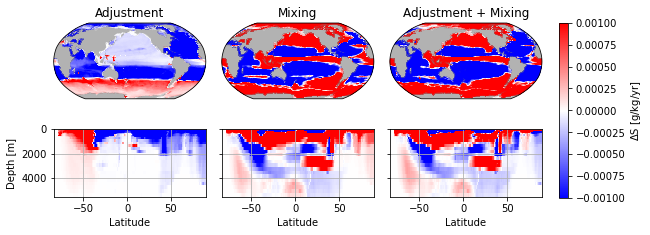

In [41]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,9, height_ratios = [2,1])
gs.update(wspace = 0.4, hspace=0)

minv, maxv = -0.001,0.001

ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

ax4, ax5, ax6 = plt.subplot(gs[1,:3]), \
           plt.subplot(gs[1,3:6]), \
           plt.subplot(gs[1,6:]) \

((dS_mix*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
    ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax2.set_title('Mixing')
((dS_adj*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
    ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax1.set_title('Adjustment')
(((dS_adj+dS_mix)*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
    ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax3.set_title('Adjustment + Mixing')

((dS_mix*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax5, \
    vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
((dS_adj*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax4, \
    vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
(((dS_adj+dS_mix)*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax6, \
    vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

ax4.invert_yaxis()
ax5.invert_yaxis()
ax6.invert_yaxis()

ax4.set_ylabel('Depth [m]')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax5.set_yticklabels([])
ax6.set_yticklabels([])

ax4.set_xlabel('Latitude')
ax5.set_xlabel('Latitude')
ax6.set_xlabel('Latitude')

ax4.grid()
ax5.grid()
ax6.grid()

cax = fig.add_axes([0.927, 0.12, 0.015, 0.65])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$\Delta$S [g/kg/yr]')

if SF:
    plt.savefig('Figures/latlon_remapping_knownSF_dS_79_14.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('Figures/latlon_remapping_freerun_dS_79_06.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
CT_eul_early = data.Cons_Temp.isel(time=slice(Early_period[0],Early_period[1])).mean('time')
CT_eul_late = data.Cons_Temp.isel(time=slice(Late_period[0],Late_period[1])).mean('time')

SA_eul_early = data.Abs_Sal.isel(time=slice(Early_period[0],Early_period[1])).mean('time')
SA_eul_late = data.Abs_Sal.isel(time=slice(Late_period[0],Late_period[1])).mean('time')

# Compute Eulerian change in temperature (just a simple difference)
dT_eul=CT_eul_late-CT_eul_early
if SF: 
    # Compute depth integrated heat content (units: W/m^2)
    dH_mix = Cp*rho*(dT_mix*V).sum('depth')/(darea*range_yrs*yr2sec)
    dH_eul = Cp*rho*(dT_eul*V).sum('depth')/(darea*range_yrs*yr2sec)
    dH_adj = Cp*rho*(dT_adj*V).sum('depth')/(darea*range_yrs*yr2sec)
else:
    # Compute depth integrated heat content (units: W/m^2)
    dH_mix = Cp*rho*(dT_mix*V).sum('depth')/(darea*range_yrs*yr2sec)
    dH_eul = Cp*rho*(dT_eul*V).sum('depth')/(darea*range_yrs*yr2sec)
    dH_adj = Cp*rho*(dT_adj*V).sum('depth')/(darea*range_yrs*yr2sec)

dH_redist = dH_eul-dH_adj

# # Compare Mixing, Redistribution and Adjustment fresh water change
# # Compute Eulerian change in temperature (just a simple difference)
dS_eul=SA_eul_late-SA_eul_early
if SF: 
    # Compute implied fresh water content change (units: mm/yr)
    dW_mix = (-1/S0)*(dS_mix*V).sum('depth')/(darea*range_yrs)*1000
    dW_eul = (-1/S0)*(dS_eul*V).sum('depth')/(darea*range_yrs)*1000
    dW_adj = (-1/S0)*(dS_adj*V).sum('depth')/(darea*range_yrs)*1000
else:
    # Compute implied fresh water content change (units: mm/yr)
    dW_mix = (-1/S0)*(dS_mix*V).sum('depth')/(darea*range_yrs)*1000
    dW_eul = (-1/S0)*(dS_eul*V).sum('depth')/(darea*range_yrs)*1000
    dW_adj = (-1/S0)*(dS_adj*V).sum('depth')/(darea*range_yrs)*1000

dW_redist = dW_eul - dW_adj

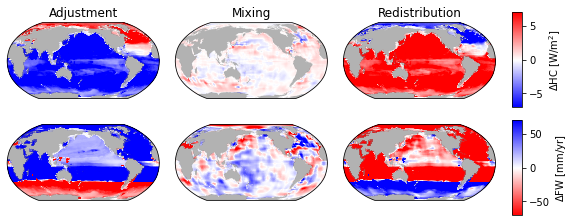

In [43]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,9, height_ratios = [1,1])
gs.update(wspace = 0.4, hspace=0)

minv, maxv = -7,7

ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

ax4, ax5, ax6 = plt.subplot(gs[1,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[1,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[1,6:], projection=ccrs.Robinson(central_longitude=180)) \

dH_adj.plot(\
    ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
dH_eul.plot(\
    ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax1.set_title('Adjustment')
ax2.set_title('Mixing')
dH_redist.plot(\
    ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax3.set_title('Redistribution')

minv, maxv = -70,70

dW_adj.plot(\
    ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
dW_eul.plot(\
    ax = ax5, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
dW_redist.plot(\
    ax = ax6, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

cax = fig.add_axes([0.927, 0.12, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$\Delta$FW [mm/yr]')

minv, maxv = -7,7

cax = fig.add_axes([0.927, 0.52, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('$\Delta$HC [W/m$^2$]')

if SF:
    plt.savefig('Figures/latlon_remapping_knownSF_OHC_FW_79_14.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('Figures/latlon_remapping_freerun_OHC_FW_79_06.png', dpi=300, bbox_inches='tight')

plt.show()

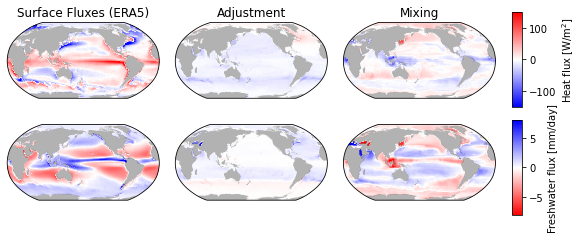

In [44]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,9, height_ratios = [1,1])
    gs.update(wspace = 0.4, hspace=0)

    minv, maxv = -150,150

    ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

    ax4, ax5, ax6 = plt.subplot(gs[1,:3], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[1,3:6], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[1,6:], projection=ccrs.Robinson(central_longitude=180)) \

    dH_adj.plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    hfds_ERA5.plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Surface Fluxes (ERA5)')
    ax2.set_title('Adjustment')
    dH_mix.plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('Mixing')

    minv, maxv = -8,8

    (dW_adj/365.25).plot(\
        ax = ax5, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    (wfo_ERA5).plot(\
        ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    (dW_mix/365.25).plot(\
        ax = ax6, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax4.set_title('')
    ax5.set_title('')
    ax6.set_title('')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.927, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Freshwater flux [mm/day]')

    minv, maxv = -150,150

    cax = fig.add_axes([0.927, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('Heat flux [W/m$^2$]')

    plt.savefig('Figures/latlon_remapping_knownSF_comp.png', dpi=300, bbox_inches='tight')

    plt.show()

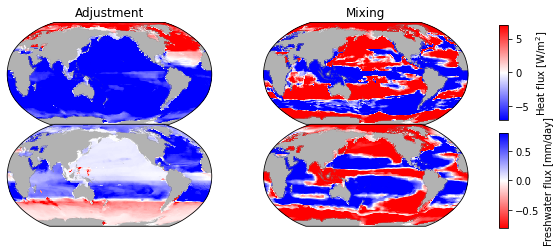

In [45]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,6, height_ratios = [1,1])
gs.update(wspace = 0.4, hspace=0)

minv, maxv = -5,5

ax1, ax2 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180))

ax3, ax4 = plt.subplot(gs[1,:3], projection=ccrs.Robinson(central_longitude=180)), \
        plt.subplot(gs[1,3:6], projection=ccrs.Robinson(central_longitude=180))
dH_adj.plot(\
    ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
        add_colorbar=False)
ax1.set_title('Adjustment')
dH_mix.plot(\
    ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
        add_colorbar=False)
ax2.set_title('Mixing')

minv, maxv = -0.8,0.8

(dW_adj/365.25).plot(\
    ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
        add_colorbar=False)
(dW_mix/365.25).plot(\
    ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
        add_colorbar=False)
ax4.set_title('')
ax3.set_title('')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

cax = fig.add_axes([0.927, 0.12, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Freshwater flux [mm/day]')

minv, maxv = -7,7

cax = fig.add_axes([0.927, 0.52, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('Heat flux [W/m$^2$]')

plt.savefig('Figures/latlon_remapping_freerun.png', dpi=300, bbox_inches='tight')

plt.show()

In [46]:
import matplotlib.path as mpath


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

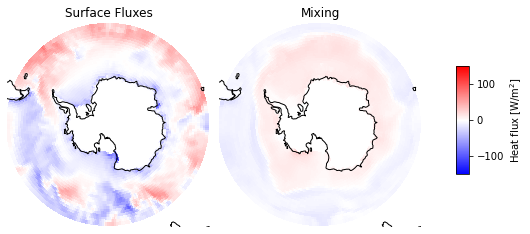

In [47]:
fig  = plt.figure(1, figsize = (7.5, 7.5))
gs = gridspec.GridSpec(2,4, height_ratios = [1,1])
gs.update(wspace = 0.05, hspace=0)

ax1, ax2 = plt.subplot(gs[0,:2], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,2:], projection=ccrs.SouthPolarStereo())

(dH_adj+hfds_ERA5).sel(lat=slice(-90,-50)).plot(ax=ax1,
             transform=ccrs.PlateCarree(), vmin=-150, vmax=150, \
             cmap=plt.cm.bwr, add_colorbar=False)
ax1.set_extent([-180.5, 180.5, -90, -49], ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Surface Fluxes')


dH_mix.sel(lat=slice(-90,-50)).plot(ax=ax2,
             transform=ccrs.PlateCarree(), vmin=-150, vmax=150, \
                cmap=plt.cm.bwr, add_colorbar=False)
ax2.set_extent([-180.5, 180.5, -90, -49], ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Mixing')
ax1.axis('off')
ax2.axis('off')

minv, maxv = -150,150

cax = fig.add_axes([0.96, 0.6, 0.025, 0.2])

m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('Heat flux [W/m$^2$]')

plt.savefig('Figures/SO_HF_Mixing.png', bbox_inches='tight', dpi=300)
plt.show()


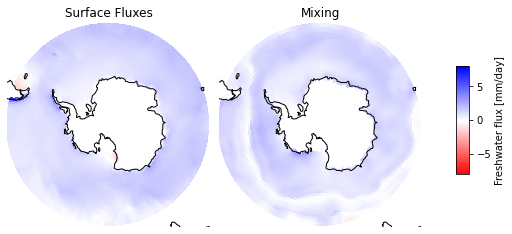

In [48]:
fig  = plt.figure(1, figsize = (7.5, 7.5))
gs = gridspec.GridSpec(2,4, height_ratios = [1,1])
gs.update(wspace = 0.05, hspace=0)

ax1, ax2 = plt.subplot(gs[0,:2], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,2:], projection=ccrs.SouthPolarStereo())

(dW_adj/356.25+wfo_ERA5).sel(lat=slice(-90,-50)).plot(ax=ax1,
             transform=ccrs.PlateCarree(), vmin=-8, vmax=8, \
             cmap=plt.cm.bwr_r, add_colorbar=False)
ax1.set_extent([-180.5, 180.5, -90, -49], ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Surface Fluxes')

(dW_mix/365.25).sel(lat=slice(-90,-50)).plot(ax=ax2,
             transform=ccrs.PlateCarree(), vmin=-8, vmax=8, \
                cmap=plt.cm.bwr, add_colorbar=False)
ax2.set_extent([-180.5, 180.5, -90, -49], ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Mixing')
ax1.axis('off')
ax2.axis('off')

minv, maxv = -8,8

cax = fig.add_axes([0.96, 0.6, 0.025, 0.2])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Freshwater flux [mm/day]')

plt.savefig('Figures/SO_WF_Mixing.png', bbox_inches='tight', dpi=300)
plt.show()

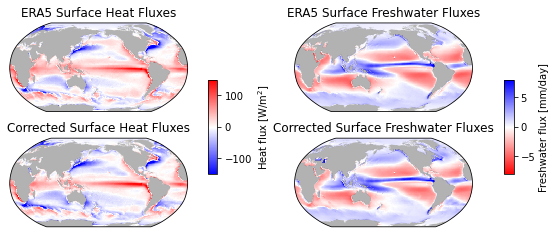

In [49]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.4, hspace=0.3)

    minv, maxv = -150,150

    ax2, ax3 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180))


    ax1, ax4 = plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)), \
                plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    (dH_adj+hfds_ERA5).plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Corrected Surface Heat Fluxes')

    (hfds_ERA5).plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax2.set_title('ERA5 Surface Heat Fluxes')

    minv, maxv = -8,8

    (dW_adj/365.25+wfo_ERA5).plot(\
        ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax4.set_title('Corrected Surface Freshwater Fluxes')

    (wfo_ERA5).plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('ERA5 Surface Freshwater Fluxes')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.93, 0.32, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Freshwater flux [mm/day]')

    minv, maxv = -150,150

    cax = fig.add_axes([0.46, 0.32, 0.015, 0.35])

    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('Heat flux [W/m$^2$]')

    plt.savefig('Figures/Corrected_fluxes_knownSF_comp.png', dpi=300, bbox_inches='tight')

    plt.show()